In [15]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [16]:
MildDemented_dir = r'data\AugmentedAlzheimerDataset\MildDemented'
ModerateDemented_dir = r'data\AugmentedAlzheimerDataset\ModerateDemented'
NonDemented_dir = r'data\AugmentedAlzheimerDataset\NonDemented'
VeryMildDemented_dir = r'data\AugmentedAlzheimerDataset\VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
df = pd.DataFrame(Alzheimer_data)
print(df.head())
print(df["labels"].value_counts())

                                           filepaths         labels
0  data\AugmentedAlzheimerDataset\MildDemented\00...  Mild Demented
1  data\AugmentedAlzheimerDataset\MildDemented\00...  Mild Demented
2  data\AugmentedAlzheimerDataset\MildDemented\00...  Mild Demented
3  data\AugmentedAlzheimerDataset\MildDemented\00...  Mild Demented
4  data\AugmentedAlzheimerDataset\MildDemented\00...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [17]:
df.shape

(33984, 2)

In [18]:
train_img, test_img = train_test_split(df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(df, test_size=0.2, random_state=42)

In [19]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_img,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 27187 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [20]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

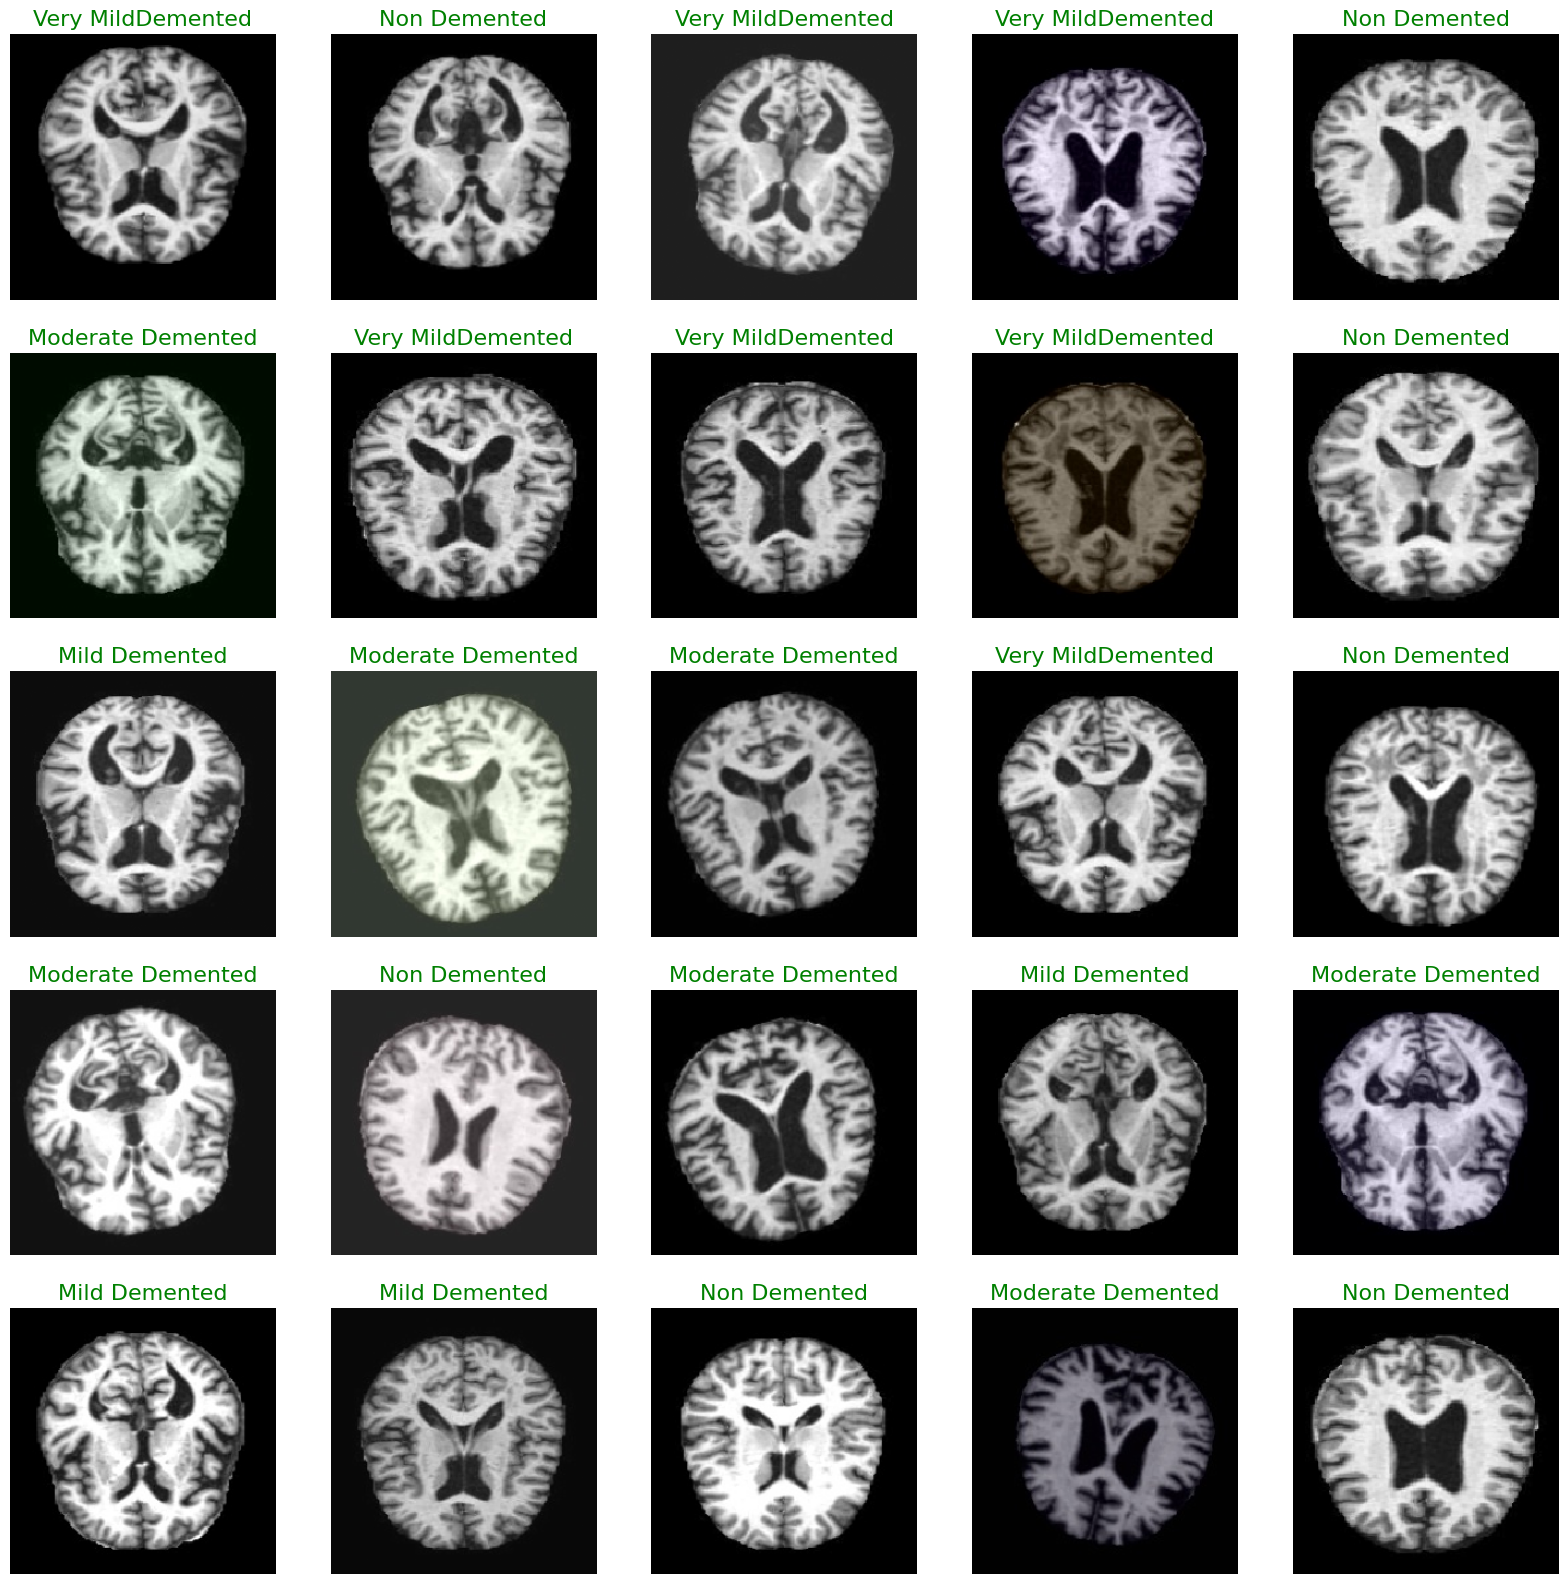

In [21]:
show_knee_images(train)

In [22]:
model = Sequential([
    Conv2D(8, (2, 2), activation='relu', input_shape=(244, 244, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 243, 243, 8)    │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 121, 121, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 117128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │     1,874,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,874,236 (7.15 MB)

 Trainable params: 1,874,236 (7.15 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

In [24]:
history = model.fit(train, epochs=20, validation_data=val) 

Epoch 1/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 69s 81ms/step - accuracy: 0.3016 - loss: 1.3836 - val_accuracy: 0.4105 - val_loss: 1.2682
Epoch 2/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 67s 79ms/step - accuracy: 0.4041 - loss: 1.2477 - val_accuracy: 0.3909 - val_loss: 1.2150
Epoch 3/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 68s 79ms/step - accuracy: 0.4209 - loss: 1.1922 - val_accuracy: 0.3891 - val_loss: 1.1918
Epoch 4/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 76s 89ms/step - accuracy: 0.4243 - loss: 1.1617 - val_accuracy: 0.4679 - val_loss: 1.1224
Epoch 5/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 69s 81ms/step - accuracy: 0.4567 - loss: 1.1275 - val_accuracy: 0.4621 - val_loss: 1.0954
Epoch 6/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 78s 92ms/step - accuracy: 0.4772 - loss: 1.0882 - val_accuracy: 0.4629 - val_loss: 1.0944
Epoch 7/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 74s 86ms/step - accuracy: 0.4941 - loss: 1.0632 - val_accuracy: 0.5014 - val_loss: 1.0794
Epoch 8/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 72s 85ms/step - accuracy: 0.5103 - loss: 1.0278 - 

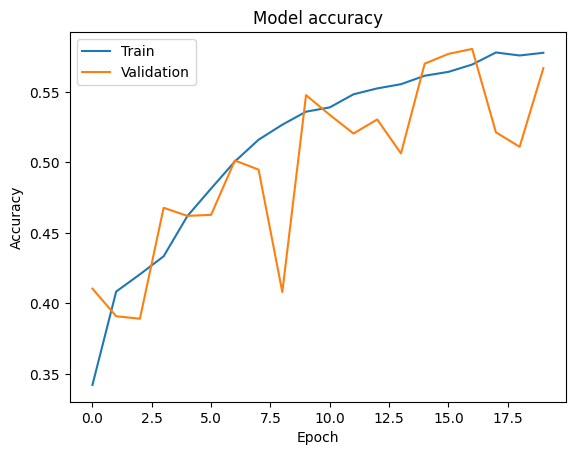

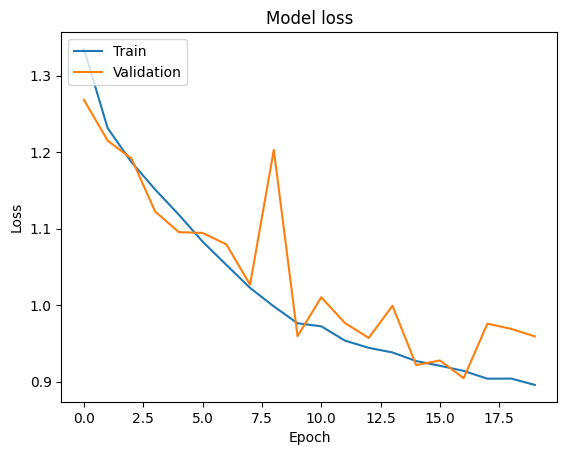

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()